In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

from torch.distributions.log_normal import LogNormal

# Internal packages
from data_loader import KidneyStoneDataset, ToTensor
from model import binary_ks_net, binary_neg_loglik, cont_rec_ks_net, cont_rec_neg_loglik, cont_size_ks_net, cont_size_neg_loglik
from train import train

In [2]:
# For graphing purposes below
import matplotlib.pyplot as plt 
import seaborn as sns

from torch.distributions.bernoulli import Bernoulli 
from torch.distributions.normal import Normal

import numpy as np

In [13]:
# Hyperparameters
BATCH_SIZE = 128
EPOCHS     = 150
LEARN_R    = 5e-4 #1e-3 #1e-2 # RMS
N_HU       = 8
#NLA = torch.tanh #torch.sigmoid #F.relu 
NLA = nn.LeakyReLU(1) # For a linear neural network

mean_idx = [2]
sd_idx = [0, 2] # Standarize the two continuous variables

# Initialize the dataset
data = KidneyStoneDataset("./data/ks_non_linear_data_lp.npy", transform=ToTensor(), idx_mean=mean_idx, idx_sd=sd_idx)
#data = KidneyStoneDataset("./data/ks_non_linear_data_lp.npy", transform=ToTensor(), idx_mean=mean_idx, idx_sd=sd_idx)
train_loader = DataLoader(data, batch_size=BATCH_SIZE)

# Initialize the model
model = cont_size_ks_net(N_HU, NLA)

# Optimizers
#optimizer = optim.SGD(model.parameters(), lr=LEARN_R)
optimizer = optim.RMSprop(model.parameters(), lr=LEARN_R)

In [15]:
cum_loss = train(model, optimizer, cont_size_neg_loglik, train_loader, EPOCHS)

In [16]:
# Ancestral sampling
########################### KS SAMPLES ###########################
# First, we get the parameters of the size variable:
n_samples = 2000
arbitrary_query = torch.tensor([1., 1., 1.]) # It is only important that the first element is 1

# Extract the parameters
mu_L, log_sigma_L, _, _, _ = model(arbitrary_query.unsqueeze(0))
sigma_L = torch.exp(log_sigma_L)

# Sample from the distribution
L_dist = LogNormal(mu_L, sigma_L)
L_samples = L_dist.sample((n_samples,)).view(n_samples,1)

########################### T SAMPLES ###########################
_, _, p_T, _, _ = model(torch.cat((L_samples, torch.ones(n_samples, 2)), 1))

T_dist = Bernoulli(p_T)
T_samples = T_dist.sample().view(n_samples,1)

########################### R SAMPLES ###########################
_, _, _, mu_R, log_sigma_R = model(torch.cat((L_samples, T_samples, torch.ones(n_samples, 1)), 1))

sigma_R = torch.exp(log_sigma_R)

R_dist = Normal(mu_R, sigma_R)
R_samples = R_dist.sample().view(n_samples,1)

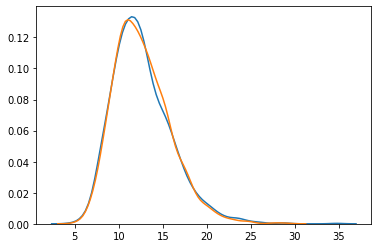

In [17]:
ax = sns.kdeplot((L_samples*data.sd[0]).numpy()[:,0])
ax = sns.kdeplot(data.ks_dataset[:,0])

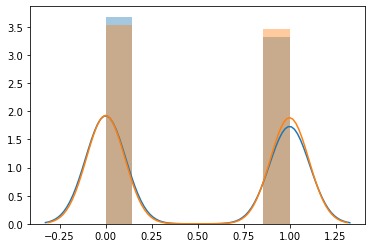

In [18]:
ax = sns.distplot((T_samples).detach().numpy()[:,0])
ax = sns.distplot(data.ks_dataset[:,1])

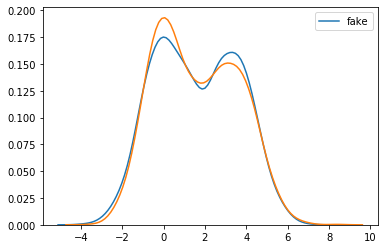

In [19]:
ax = sns.kdeplot((R_samples*data.sd[2]+data.mean[2]).numpy()[:,0], label="fake")
ax = sns.kdeplot(data.ks_dataset[:,2])

In [20]:
# Ancestral sampling
########################### KS SAMPLES ###########################
# First, we get the parameters of the size variable:
L_samples = torch.arange(5, 25, 0.1)/data.sd[0]
n = L_samples.shape[0]

########################### T SAMPLES ###########################
T1_samples = torch.ones(n, 1)
T0_samples = torch.zeros(n, 1)

########################### R SAMPLES ###########################
# T1
_, _, _, mu_R1, log_sigma_R1 = model(torch.cat((L_samples.view(-1,1), T1_samples, torch.ones(n, 1)), 1))

sigma_R1 = torch.exp(log_sigma_R1)

R1_dist = Normal(mu_R1, sigma_R1)
R1_samples = R1_dist.sample().view(n,1)

#T0
_, _, _, mu_R0, log_sigma_R0 = model(torch.cat((L_samples.view(-1,1), T0_samples, torch.ones(n, 1)), 1))

sigma_R0 = torch.exp(log_sigma_R0)

R0_dist = Normal(mu_R0, sigma_R0)
R0_samples = R0_dist.sample().view(n,1)

In [29]:
# First run NN and save as neural_TE, then run linear and save as TE
TE = ((mu_R1*data.sd[2]+data.mean[2])-(mu_R0*data.sd[2]+data.mean[2])).detach().numpy()

In [ ]:
ax = sns.lineplot(x=(L_samples*data.sd[0]).numpy(), y=((mu_R1*data.sd[2])+data.mean[2]).detach().numpy()[:,0], label="T==1")
ax = sns.lineplot(x=(L_samples*data.sd[0]).numpy(), y=((mu_R0*data.sd[2])+data.mean[2]).detach().numpy()[:,0], label="T==0")
ax = sns.lineplot(x=(L_samples*data.sd[0]).numpy(), y=neural_TE[:,0], label="Treatment effect")

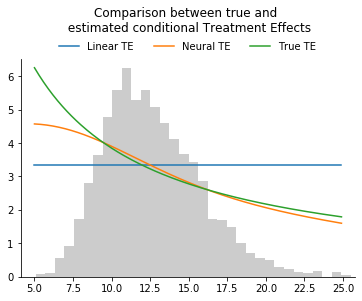

In [81]:
# In order to run this cell, one must save the results from the neural model before
ax = sns.lineplot(x=(L_samples*data.sd[0]).numpy(), y=TE[:,0], label="Linear TE")
ax = sns.lineplot(x=(L_samples*data.sd[0]).numpy(), y=neural_TE[:,0], label="Neural TE")
ax = sns.lineplot(x=(L_samples*data.sd[0]).numpy(), y=(50/(3+L_samples*data.sd[0])).numpy(), label="True TE")
ax = sns.distplot(data.ks_dataset[:,0], hist=True, kde=False, color='silver', hist_kws={'alpha': 0.8, 'weights':0.028*np.ones(len(data.ks_dataset))})
#ax = sns.distplot(data.ks_dataset[:,0], rug=True, hist=False, kde=False)

plt.title("Comparison between true and \n estimated conditional Treatment Effects", y=1.10)
ax.legend(loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.10), borderaxespad=0, frameon=False)

ax.set_xlim(4.1, 25.8)
ax.set_ylim(0, 6.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig("./results/linear_vs_non-linear_hist.pdf", ppi=300, bbox_inches='tight');

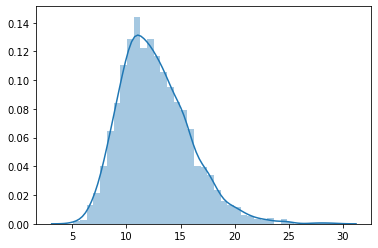

In [32]:
ax = sns.distplot(data.ks_dataset[:,0])

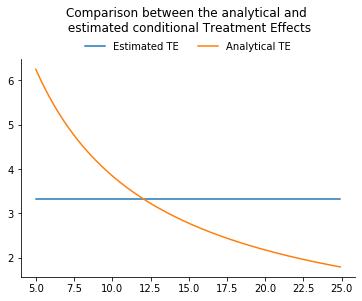

In [24]:
ax = sns.lineplot(x=(L_samples*data.sd[0]).numpy(), y=TE[:,0], label="Estimated TE")
ax = sns.lineplot(x=(L_samples*data.sd[0]).numpy(), y=(50/(3+L_samples*data.sd[0])).numpy(), label="Analytical TE")

plt.title("Comparison between the analytical and \n estimated conditional Treatment Effects", y=1.10)
ax.legend(loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.10), borderaxespad=0, frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig("./results/non-linear.pdf", ppi=300, bbox_inches='tight');

In [20]:
mu    = 2.5
sigma = 0.25

# Simulation
size = np.arange(0, 25, step =0.1)        # Simulation of kidney stone size
norm_size = size-np.mean(size)
p = 1/(1+np.exp(-norm_size/10)) # Original p = 1/(1+np.exp(-norm_size))
a = np.random.binomial(1, p) # Simulation of treatment
r = np.random.normal((50*a)/(size+3), 1, size=len(size)) # Simulation of recovery

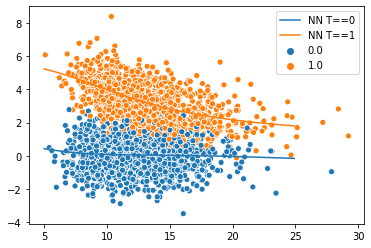

In [21]:
ax = sns.scatterplot(x=data.ks_dataset[:,0], y=data.ks_dataset[:,2], hue=data.ks_dataset[:,1])
ax = sns.lineplot(x=(L_samples*data.sd[0]).numpy(), y=((mu_R0*data.sd[2])+data.mean[2]).detach().numpy()[:,0], label="NN T==0")
ax = sns.lineplot(x=(L_samples*data.sd[0]).numpy(), y=((mu_R1*data.sd[2])+data.mean[2]).detach().numpy()[:,0], label="NN T==1")

In [30]:
np.mean(np.abs(analytical_TE[100:]-TE[:,0][100:]))

0.050798416